https://discourse.pymc.io/t/mixture-model-with-boxcox-transformation/988

In [1]:
%pylab inline
import pymc3 as pm
from pymc3.theanof import gradient, floatX
from scipy import special
import numpy.testing as npt
import theano.tensor as tt
import theano

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with pm.Model() as m:
    x = pm.Lognormal('x', 0., .25)
    x_ = pm.Normal('x_', 0., .25)
    xlog = pm.Deterministic('xlog', tt.exp(x_))
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_, x_log__]
100%|██████████| 6000/6000 [00:05<00:00, 1166.36it/s]


In [3]:
m.free_RVs, m.deterministics

([x_log__, x_], [x, xlog])

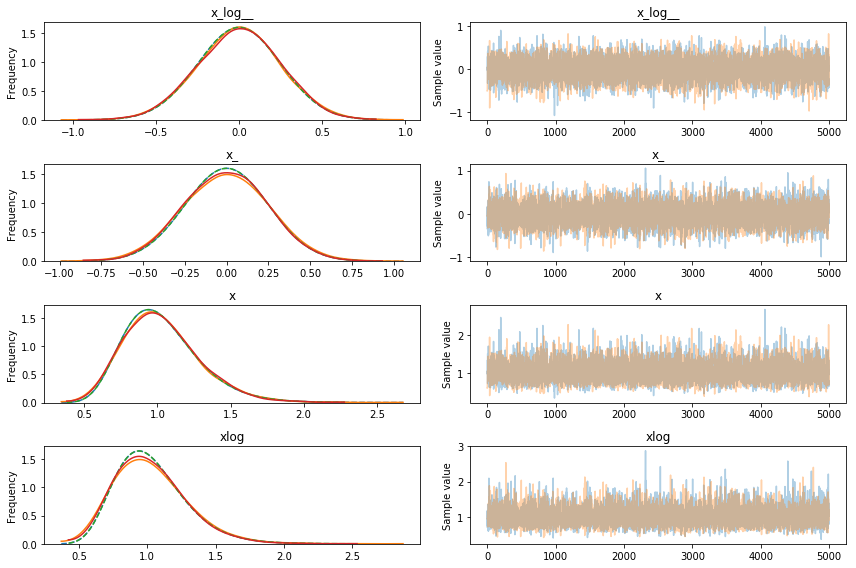

In [4]:
x_tr = m.free_RVs[0]
x1 = m.free_RVs[1]
pm.traceplot(trace, plot_transformed=True, priors=[x_tr.distribution,
                                                   x1.distribution,
                                                   x.distribution,
                                                   x.distribution]);

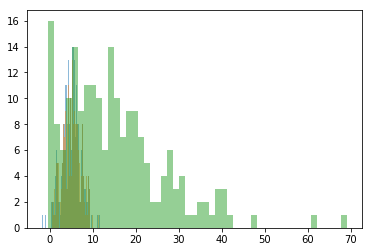

In [5]:
mu0, sd0 = 5., 2.
y = np.random.normal(mu0, sd0, size=200)
lam = 2.
y_tr = (np.power(y, lam) - 1.) / lam
plt.hist(y, bins=50, alpha=.5)
inv_boxcox = lambda x: np.power(x * lam + 1., 1. / lam)
plt.hist(inv_boxcox(y_tr), bins=50, alpha=.5);
plt.hist(y_tr, bins=50, alpha=.5);
# plt.hist(special.boxcox(y, lam), bins=50, alpha=.5);

In [6]:
from pymc3.distributions.transforms import ElemwiseTransform

class BoxCox(ElemwiseTransform):
    """Box-Cox transformation from real line to real line"""

    name = "boxcox"

    def __init__(self, lmbda):
        self.lmbda = tt.as_tensor_variable(lmbda)

    def backward(self, x):
        return tt.exp(tt.log1p(self.lmbda * x) / self.lmbda)

    def forward(self, y):
        return tt.expm1(self.lmbda * tt.log(y)) / self.lmbda

    def forward_val(self, y, point=None):
        lmbda = draw_values([self.lmbda], point=point)
        return np.expm1(lmbda * np.log(y)) / lmbda

    def jacobian_det(self, x):
        x = tt.as_tensor_variable(x)
        grad = tt.reshape(gradient(tt.sum(self.backward(x)), [x]), x.shape)
        return tt.log(tt.abs_(grad))


boxcox = BoxCox(lam)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd_log__, mu]
100%|██████████| 2000/2000 [00:03<00:00, 614.64it/s]


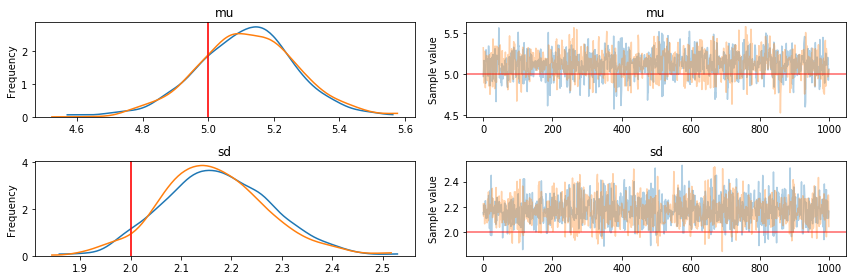

In [7]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 100.)
    sd = pm.HalfNormal('sd', 5.)
    obs = pm.Normal('y', mu, sd, observed=boxcox.backward(y_tr))
    trace = pm.sample(1000, tune=1000)

pm.traceplot(trace, lines=dict(mu=mu0, sd=sd0));

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x_boxcox__]
100%|██████████| 6000/6000 [00:06<00:00, 873.25it/s] 
There were 1507 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1784 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


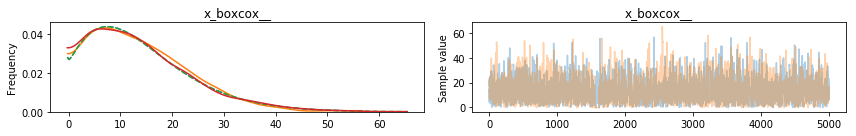

In [8]:
with pm.Model() as m:
    x = pm.Normal('x', mu0, sd0, transform=boxcox)
    trace = pm.sample(5000, tune=1000)

x_tr = m.free_RVs[0]
pm.traceplot(trace, varnames=[x_tr.name], priors=[x_tr.distribution]);

In [9]:
x_tr = m.free_RVs[0]
jac = x_tr.distribution.transform_used.jacobian_det(theano.shared(np.array([-1, 2])))
print(x.ndim, x_tr.logp_elemwiset.ndim, jac.ndim)

0 0 1


In [10]:
def check_elementwise_logp_transform(model):
    x0 = model.deterministics[0]
    x = model.free_RVs[0]
    npt.assert_equal(x.ndim, x.logp_elemwiset.ndim)
    
    pt = model.test_point
    array = np.random.randn(*model.bijection.map(pt).shape)
    pt2 = model.bijection.rmap(array)
    dist = x.distribution
    logp_nojac = x0.distribution.logp(dist.transform_used.backward(pt2[x.name]))
    jacob_det = dist.transform_used.jacobian_det(theano.shared(pt2[x.name]))
    npt.assert_equal(x.logp_elemwiset.ndim, jacob_det.ndim)
    elementwiselogp = logp_nojac + jacob_det
                      
    npt.assert_array_almost_equal(x.logp_elemwise(pt2),
                                  elementwiselogp.eval())
    
check_elementwise_logp_transform(m)

In [11]:
with pm.Model() as m:
    mu = pm.Normal('mu', 0., 10.)
    sd = pm.HalfNormal('sd', 5.)
    y_latent = pm.Normal('y', mu, sd, transform=boxcox, testval=2.)

In [12]:
m.free_RVs

[mu, sd_log__, y_boxcox__]

In [13]:
y_boxcox = m.free_RVs[2]

with m:
    obs = pm.Potential('obs', y_boxcox.distribution.logp(theano.shared(y_tr)))

In [14]:
m.check_test_point()

mu           -3.22
sd_log__     -0.77
y_boxcox__   -3.12
Name: Log-probability of test_point, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_boxcox__, sd_log__, mu]
100%|██████████| 6000/6000 [00:13<00:00, 449.84it/s]
There were 2135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2183 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


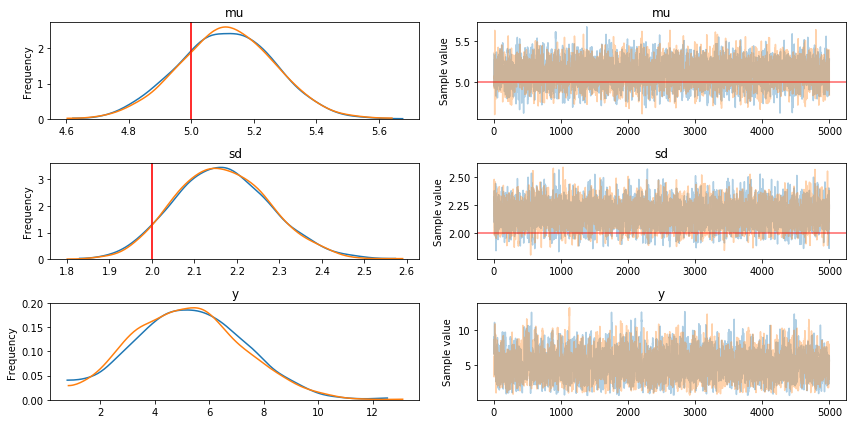

In [15]:
with m:
    trace = pm.sample(5000, tune=1000)

pm.traceplot(trace, lines=dict(mu=5., sd=2.));